# CTCF L pos & neg (5%) | rle & 3-mer features

In [1]:
library(ggplot2)
library(data.table)
library(plyr)
library(dplyr)
library(tictoc)
library(ggsci)
library(purrr)
library(scales)
library(stringr)
library(cowplot)
library(gridExtra)
library(tidyr)


Attaching package: ‘dplyr’


The following objects are masked from ‘package:plyr’:

    arrange, count, desc, failwith, id, mutate, rename, summarise,
    summarize


The following objects are masked from ‘package:data.table’:

    between, first, last


The following objects are masked from ‘package:stats’:

    filter, lag


The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union



Attaching package: ‘tictoc’


The following object is masked from ‘package:data.table’:

    shift



Attaching package: ‘purrr’


The following object is masked from ‘package:plyr’:

    compact


The following object is masked from ‘package:data.table’:

    transpose


The following object is masked from ‘package:jsonlite’:

    flatten



Attaching package: ‘scales’


The following object is masked from ‘package:purrr’:

    discard



Attaching package: ‘gridExtra’


The following object is masked from ‘package:dplyr’:

    combine




In [2]:
while (!is.null(dev.list()))  dev.off()
rm(list=ls())

#------------ Helper Functions ------------
# Initiate PDF
openPDF <- function (output_file_fh, pdf_dims) {
  print(sprintf("Saving plots to: %s", output_file_fh))
  # Open PDF
  pdf(output_file_fh, width = pdf_dims[1], height = pdf_dims[2],
      useDingbats=FALSE, family = "ArialMT")
}

# Close PDF
closePDF <- function () {
  while (!is.null(dev.list()))  dev.off()
  print("File saved.")
}

In [3]:
#------------ Define dirs ------------
setwd("/mmfs1/gscratch/stergachislab/mwperez/ctcf-footprinting")

#ARGS
data_folder <- sprintf("%s/candidate_footprints", getwd())
mokapot_dir <- sprintf("%s/mokapot_res", getwd())
output_folder <- sprintf("%s/figures", mokapot_dir)

## formatting data

In [4]:
# set args
motif_type <- "L"
input_file_root <- "100bp_L_5_v2"
file_root <- "100bp_L_rle_kmer" # for output file & titles
ctcf_dist <- c(-100,100)
n_rows <- Inf

# load set data file
data_file_name <- sprintf("CTCF_%s.mokapot.m6a_fiberseq.txt", input_file_root)
data_file <- sprintf("%s/%s", mokapot_dir, data_file_name)
print(data_file)

[1] "/mmfs1/gscratch/stergachislab/mvollger/projects/ctcf-footprinting/mokapot_res/CTCF_100bp_L_5_v2.mokapot.m6a_fiberseq.txt"


In [5]:
# read table
df <- fread(data_file, nrows=n_rows)
sprintf("m6a rows: %s", format(dim(df)[1], big.mark=",", scientific=FALSE))

# filter centered_position_type for m6a
df <- filter(df, centered_position_type == "m6a")
sprintf("m6a rows: %s", format(dim(df)[1], big.mark=",", scientific=FALSE))

[1] "m6a rows: 17,535,934"

[1] "m6a rows: 17,535,934"

In [6]:
df <- df %>%
    mutate(Label = ifelse(Label == 1, "Positive", "Negative"))

table(df$Label)


Negative Positive 
 8040195  9495739 

In [7]:
df$FDR_05 <- ifelse(df$FDR < 0.05, "low_FDR", "high_FDR")
df$FDR_01 <- ifelse(df$FDR < 0.01, "low_FDR", "high_FDR")
df$FDR_001 <- ifelse(df$FDR < 0.001, "low_FDR", "high_FDR")
df$FDR_0001 <- ifelse(df$FDR < 0.0001, "low_FDR", "high_FDR")

In [8]:
# unique CTCF motifs, queries, & motif_queries
sprintf("unique motifs: %s", format(length(unique(df$motif_name)), big.mark=",", scientific=FALSE))
sprintf("unique queries: %s", format(length(unique(df$query_name)), big.mark=",", scientific=FALSE))
sprintf("unique motif-query groups: %s", format(length(unique(df$motif_query)), big.mark=",", scientific=FALSE))

[1] "unique motifs: 260,946"

[1] "unique queries: 411,235"

[1] "unique motif-query groups: 569,891"

In [9]:
# save original df
df_og <- df

## plot & color settings

In [10]:
# change plot dimensions
options(repr.plot.width=20, repr.plot.height=10)

set_plot_dimensions <- function(width_choice, height_choice) {
options(repr.plot.width=width_choice, repr.plot.height=height_choice)
        }
set_plot_dimensions(15, 7.5)

In [11]:
# create density plot
font_size <- 1
font_info <- element_text(size=font_size, family="ArialMT", color="black")

In [12]:
# define colors (light grey, purple, darker grey, blue)
m6a_col <- "#7F3F98"
fiber_col <- "#D1D2D4"
motif_annot_col <- "#006738"#"#6C9272"#"blue"

# colors from Mitchell's presentation (orange, red, purple, light grey, navy (gene track))
mitch_cols <- c("#FF8C00", "#FF0000", "#9370DB", "#E6E6E6", "#0C0C78")

## feature hists

In [15]:
#------------ Example motif data ------------

# load data file
data_file_name <- "CTCF_m6a_fiberseq_100bp_fig_example_positive.txt"
data_file <- sprintf("%s/%s", data_folder, data_file_name)
print(data_file)

# read table
df <- fread(data_file)

# add motif_name row
df$motif_name <- paste(df$chrom, df$centering_position, df$strand, sep="_")
# move motif_name to first column
df <- df %>%
    select("motif_name", everything())

# add motif_query column
df <- cbind(paste(df$motif_name, df$query_name, sep="/"), df)
# rename column
colnames(df)[1] = "motif_query"

# get only m6a
df <- df[df$centered_position_type %in% c("m6a")]
# filter our rows with N in sequence
df <- df %>% filter(!(grepl("N", subset_sequence)))

[1] "/mmfs1/gscratch/stergachislab/mvollger/projects/ctcf-footprinting/candidate_footprints/CTCF_m6a_fiberseq_100bp_fig_example_positive.txt"


In [41]:
# set args
feature_dir <- sprintf("%s/feature_data", getwd())
motif_type <- "L"
input_file_root <- "rle-v3"
#file_root <- "100bp_L_rle_all" # for output file & titles
ctcf_dist <- c(-100,100)
n_rows <- Inf

# set data file
data_file_name <- sprintf("CTCF_m6a_fiberseq_L_100bp_positive_features-%s.txt", input_file_root)
data_file <- sprintf("%s/%s", feature_dir, data_file_name)
print(data_file)

# read table
d_p <- fread(data_file, nrows=n_rows)
sprintf("feature rows: %s", format(dim(d_p)[1], big.mark=",", scientific=FALSE))

[1] "/mmfs1/gscratch/stergachislab/mvollger/projects/ctcf-footprinting/feature_data/CTCF_m6a_fiberseq_L_100bp_positive_features-rle-v3.txt"


[1] "feature rows: 238,348"

In [43]:
# set data file
data_file_name <- sprintf("CTCF_m6a_fiberseq_L_100bp_small_5_negative_features-%s.txt", input_file_root)
data_file <- sprintf("%s/%s", feature_dir, data_file_name)
print(data_file)

# read table
d_n <- fread(data_file, nrows=n_rows)
sprintf("feature rows: %s", format(dim(d_n)[1], big.mark=",", scientific=FALSE))

[1] "/mmfs1/gscratch/stergachislab/mvollger/projects/ctcf-footprinting/feature_data/CTCF_m6a_fiberseq_L_100bp_small_5_negative_features-rle-v3.txt"


[1] "feature rows: 331,543"

In [14]:
# read table
d_p <- fread(data_file, nrows=n_rows)
sprintf("feature rows: %s", format(dim(df)[1], big.mark=",", scientific=FALSE))

[1] "feature rows: 17,535,934"

In [17]:
head(d_p)

motif_query,motif_name,query_name,msp_size,left_m6a_count,right_m6a_count,motif_m6a_count,left_AT_count,right_AT_count,motif_AT_count,⋯,rle_26,rle_27,rle_28,rle_29,rle_30,rle_31,rle_32,rle_33,rle_34,rle_35
<chr>,<chr>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,⋯,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
chr10_100338605_+/m54329U_210323_190418/12585455/ccs,chr10_100338605_+,m54329U_210323_190418/12585455/ccs,200,13,13,3,18,18,13,⋯,0,0,0,0,0,0,0,0,0,0
chr10_100338605_+/m54329U_210323_190418/16515087/ccs,chr10_100338605_+,m54329U_210323_190418/16515087/ccs,212,12,12,4,18,18,13,⋯,0,0,0,0,0,0,0,0,0,0
chr10_100338605_+/m54329U_210323_190418/169477611/ccs,chr10_100338605_+,m54329U_210323_190418/169477611/ccs,181,10,12,2,18,18,13,⋯,0,0,0,0,0,0,0,0,0,0
chr10_100338605_+/m54329U_210323_190418/173999297/ccs,chr10_100338605_+,m54329U_210323_190418/173999297/ccs,134,9,11,8,18,18,13,⋯,0,0,0,0,0,0,0,0,0,0
chr10_100338605_+/m54329U_210323_190418/180160021/ccs,chr10_100338605_+,m54329U_210323_190418/180160021/ccs,194,12,12,1,18,18,13,⋯,0,0,0,0,0,0,0,0,0,0
chr10_100338605_+/m54329U_210323_190418/27396441/ccs,chr10_100338605_+,m54329U_210323_190418/27396441/ccs,181,14,14,3,17,18,13,⋯,0,0,0,0,0,0,0,0,0,0


In [19]:
# get rle columns
rle_cols <- colnames(d_p)[str_detect(colnames(d_p), "rle")]

# filter for rle cols
d_p_rle <- d_p %>% select(all_of(rle_cols))
dim(d_p_rle)

[1] 238348     36

In [30]:
col_sums <- colSums(d_p_rle)
col_names <- names(d_p_rle)
rle_counts <- c()
for (i in seq_along(col_names)) {
    rle_counts <- c(rle_counts, rep(i-1, each=col_sums[col_names[i]]))
}
length(rle_counts)

[1] 1324420

In [47]:
# get individual rle counts from all rle table
get_rle_counts <- function(df, label) {
    # filter for rle cols
    rle_cols <- colnames(df)[str_detect(colnames(df), "rle")]
    df_rle <- df %>% select(all_of(rle_cols))
    
    col_sums <- colSums(df_rle)
    col_names <- names(df_rle)
    rle_counts <- c()
    for (i in seq_along(col_names)) {
        rle_counts <- c(rle_counts, rep(i-1, each=col_sums[col_names[i]]))
    }
    return(data.frame(Label=rep(label, each=length(rle_counts)), rle_counts))
}

In [49]:
# merge positive and negative rle counts
df_rles <- rbind(get_rle_counts(d_p, label="Positive"),
                 get_rle_counts(d_n, label="Negative"))
dim(df_rles)

[1] 3782084       2

### rle count hist (must use different fxn)

In [220]:
#------------ Set output file ------------
output_file_name <- sprintf("CTCF_%s.mokapot.rle_count_hist.pdf", file_root)
output_file <- sprintf("%s/%s", output_folder, output_file_name)
print(output_file)

# save file
save_pdf <- TRUE
pdf_dims <- c(10,5)

[1] "/mmfs1/gscratch/stergachislab/mvollger/projects/ctcf-footprinting/mokapot_res/figures/CTCF_100bp_L_rle_kmer.mokapot.rle_count_hist.pdf"


In [53]:
head(df_rles, 1)

,Label,rle_counts
,<chr>,<dbl>
1,Positive,0


In [60]:
library(lattice)

In [221]:
plot_title <- sprintf("(%s) total rle counts [%s, %s]\nPositive: %s, Negative: %s", 
                      "Pos & 5% L neg",
                      min(df_rles$rle_counts), max(df_rles$rle_counts),
                      format(table(df_rles$Label)["Positive"], big.mark=",", scientific=FALSE),
                      format(table(df_rles$Label)["Negative"], big.mark=",", scientific=FALSE))

In [180]:
summary(df_rles$rle_counts)

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
  0.000   0.000   0.000   1.099   1.000  27.000 

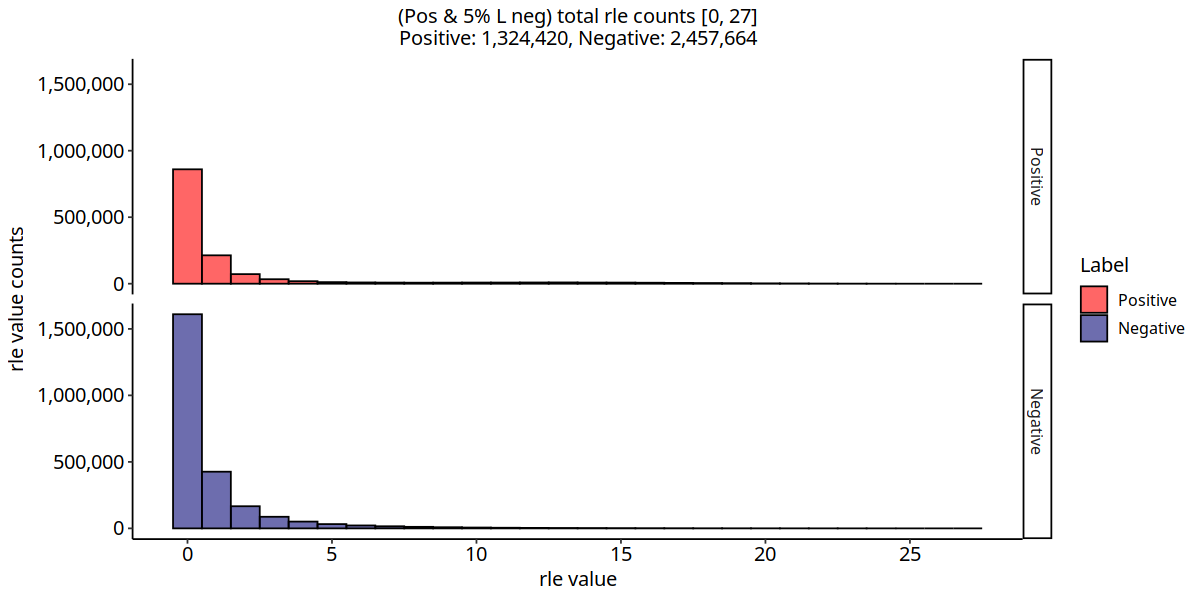

In [222]:
if (save_pdf == TRUE) {set_plot_dimensions(pdf_dims[1], pdf_dims[2])} else {set_plot_dimensions(10, 5)}

df_rles$Label <- factor(df_rles$Label, levels=c("Positive", "Negative"))
p <- ggplot(df_rles, aes(x=rle_counts, fill=Label)) +
        geom_histogram(aes(color=Label), color="black", alpha=0.6, position = 'identity', binwidth=1) +
        scale_fill_manual(values=c(mitch_cols[2], mitch_cols[5])) +
        scale_y_continuous(label=comma, name="rle value counts", breaks=pretty_breaks(n=5)) +
        scale_x_continuous(name="rle value", breaks=pretty_breaks(n=10))+ #, limits=c(NA,30)) +

        facet_grid(rows=vars(Label)) +
        ggtitle(plot_title) +
        theme_classic() +
        theme(text = font_info,
              axis.text = font_info,
              plot.title = element_text(family="ArialMT", size=12, hjust=0.5),)
p

if (save_pdf == TRUE) {ggsave(output_file, plot = p, width=pdf_dims[1], height=pdf_dims[2])}

In [152]:
# total rle counts
print("Total rle counts.")
summary(df_rles[df_rles$Label == "Positive",]$rle_counts)
summary(df_rles[df_rles$Label == "Negative",]$rle_counts)
print("Max rle.")
summary(d[d$data_set == "Negative",]$rle_max)
summary(d[d$data_set == "Positive",]$rle_max)

[1] "Total rle counts."


   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
  0.000   0.000   0.000   1.522   1.000  25.000 

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
  0.000   0.000   0.000   0.871   1.000  27.000 

[1] "Max rle."


   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
  0.000   2.000   3.000   4.038   5.000  27.000 

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
  0.000   2.000   5.000   6.981  12.000  25.000 

### max rle hist

In [132]:
# set args
input_file_root <- "rle-v4"
# set data file
data_file_name <- sprintf("CTCF_m6a_fiberseq_L_100bp_features-%s.pin", input_file_root)
data_file <- sprintf("%s/%s", feature_dir, data_file_name)
print(data_file)

# read table
d <- fread(data_file, nrows=n_rows)
sprintf("feature rows: %s", format(dim(d)[1], big.mark=",", scientific=FALSE))

[1] "/mmfs1/gscratch/stergachislab/mvollger/projects/ctcf-footprinting/feature_data/CTCF_m6a_fiberseq_L_100bp_features-rle-v4.pin"


[1] "feature rows: 569,891"

In [140]:
d$data_set <- ifelse(d$Label == 1, "Positive", "Negative")
d$data_set <- factor(d$data_set, levels=c("Positive", "Negative"))

SpecID,Label,msp_size,left_m6a_count,right_m6a_count,motif_m6a_count,left_AT_count,right_AT_count,motif_AT_count,left_AT_prop,⋯,rle_31,rle_32,rle_33,rle_34,rle_35,rle_max,Peptide,Proteins,scannr,data_set
<chr>,<int>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,⋯,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<int>,<int>,<int>,<chr>
chr10_100338605_+/m54329U_210323_190418/12585455/ccs,1,200,13,13,3,18,18,13,0.45,⋯,0,0,0,0,0,9,0,0,0,Positive


__rle max__

In [212]:
#------------ Set output file ------------
output_file_name <- sprintf("CTCF_%s.mokapot.rle_max_hist.pdf", file_root)
output_file <- sprintf("%s/%s", output_folder, output_file_name)
print(output_file)

# save file
save_pdf <- TRUE
pdf_dims <- c(10,5)

[1] "/mmfs1/gscratch/stergachislab/mvollger/projects/ctcf-footprinting/mokapot_res/figures/CTCF_100bp_L_rle_kmer.mokapot.rle_max_hist.pdf"


In [218]:
plot_title <- sprintf("(%s) max rle [%s, %s]\nPositive: %s, Negative: %s", 
    "Pos & 5% L neg",
    min(d$rle_max), max(d$rle_max),
    format(table(d$data_set)["Positive"], big.mark=",", scientific=FALSE),
    format(table(d$data_set)["Negative"], big.mark=",", scientific=FALSE))

In [216]:
# colors from Mitchell's presentation (orange, red, purple, light grey, navy (gene track))
mitch_cols <- c("#FF8C00", "#FF0000", "#9370DB", "#E6E6E6", "#0C0C78")

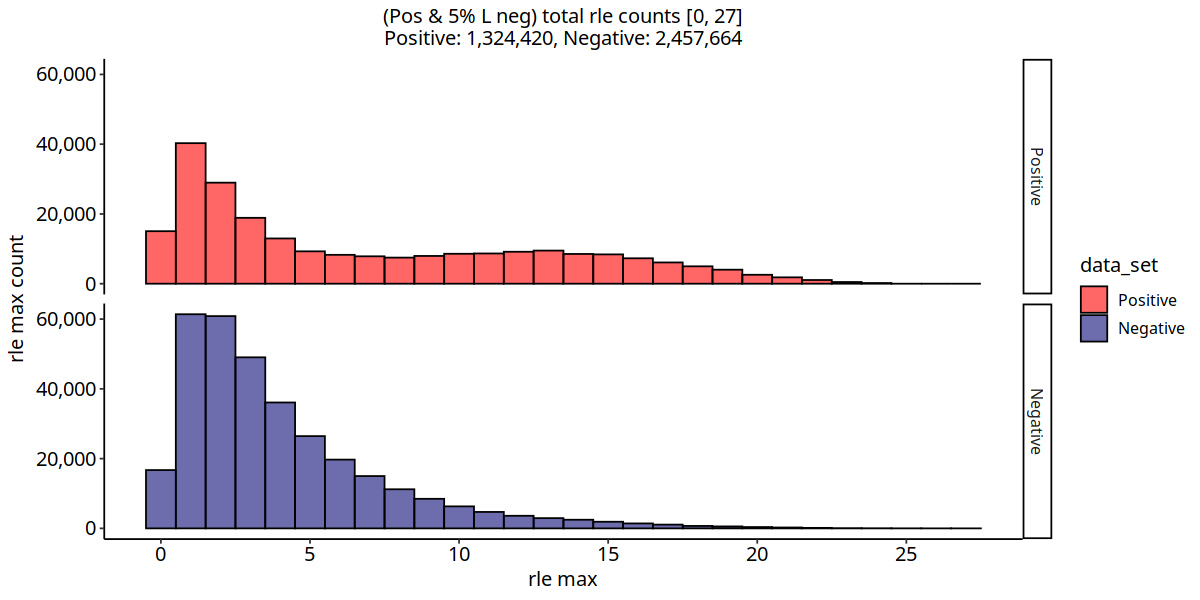

In [247]:
if (save_pdf == TRUE) {set_plot_dimensions(pdf_dims[1], pdf_dims[2])} else {set_plot_dimensions(10, 5)}

p <- ggplot(d, aes_string(x=feature, fill="data_set")) +
        geom_histogram(aes(color=data_set), color="black", 
                       alpha=0.6, position = 'identity', binwidth=1) +
        scale_fill_manual(values=c(mitch_cols[2], mitch_cols[5])) +#values=c("#132B43", "#56B1F7")) +
        scale_y_continuous(label=comma, name="rle max count", breaks=pretty_breaks(n=4)) +#,
                           #labels = function(x) format(x, scientific=TRUE)) +
        scale_x_continuous(name="rle max", breaks=pretty_breaks(n=10))+ #, limits=c(NA,30)) +

        facet_grid(rows=vars(data_set)) +
        ggtitle(plot_title) +
        theme_classic() +
        theme(text = font_info,
              axis.text = font_info,
              plot.title = element_text(family="ArialMT", size=12, hjust=0.5),)
p

if (save_pdf == TRUE) {ggsave(output_file, plot = p, width=pdf_dims[1], height=pdf_dims[2])}

In [254]:
# plot POS & NEG feature counts
plot_features <- function(df, feature) {
    feature_text <- gsub("_", " ", feature)
    plot_title <- sprintf("%s [%s, %s]\n(%s) Positive: %s, Negative: %s", 
                          feature_text, min(d[[feature]]), max(d[[feature]]),
                          "Pos & 5% L neg",
                          format(table(d$data_set)["Positive"], big.mark=",", scientific=FALSE),
                          format(table(d$data_set)["Negative"], big.mark=",", scientific=FALSE))
    
    p <- ggplot(d, aes_string(x=feature, fill="data_set")) +
            geom_histogram(aes(color=data_set), color="black",
                           alpha=0.6, position="identity", binwidth=1) +
            # set colors (positive = red, negative = blue)
            scale_fill_manual(values=c(mitch_cols[2], mitch_cols[5]), name="Data set") +
            scale_y_continuous(label=comma, name=sprintf("%s count", feature_text), breaks=pretty_breaks(n=4)) +
            scale_x_continuous(name=feature_text, breaks=pretty_breaks(n=10))+ 
            facet_grid(rows=vars(data_set)) +
            ggtitle(plot_title) +
            theme_classic() +
            theme(text = font_info,
                  axis.text = font_info,
                  plot.title = element_text(family="ArialMT", size=12, hjust=0.5),)
    return(p)
    
}

In [ ]:
if (save_pdf == TRUE) {set_plot_dimensions(pdf_dims[1], pdf_dims[2])} else {set_plot_dimensions(10, 5)}
if (save_pdf == TRUE) {ggsave(output_file, plot = p, width=pdf_dims[1], height=pdf_dims[2])}

### CGT count

In [259]:
#------------ Set output file ------------
feature <- "CGT_count"
output_file_name <- sprintf("CTCF_%s.mokapot.%s_hist.pdf", file_root, feature)
output_file <- sprintf("%s/%s", output_folder, output_file_name)
print(output_file)

# save file
save_pdf <- TRUE
pdf_dims <- c(10,5)

[1] "/mmfs1/gscratch/stergachislab/mvollger/projects/ctcf-footprinting/mokapot_res/figures/CTCF_100bp_L_rle_kmer.mokapot.CGT_count_hist.pdf"


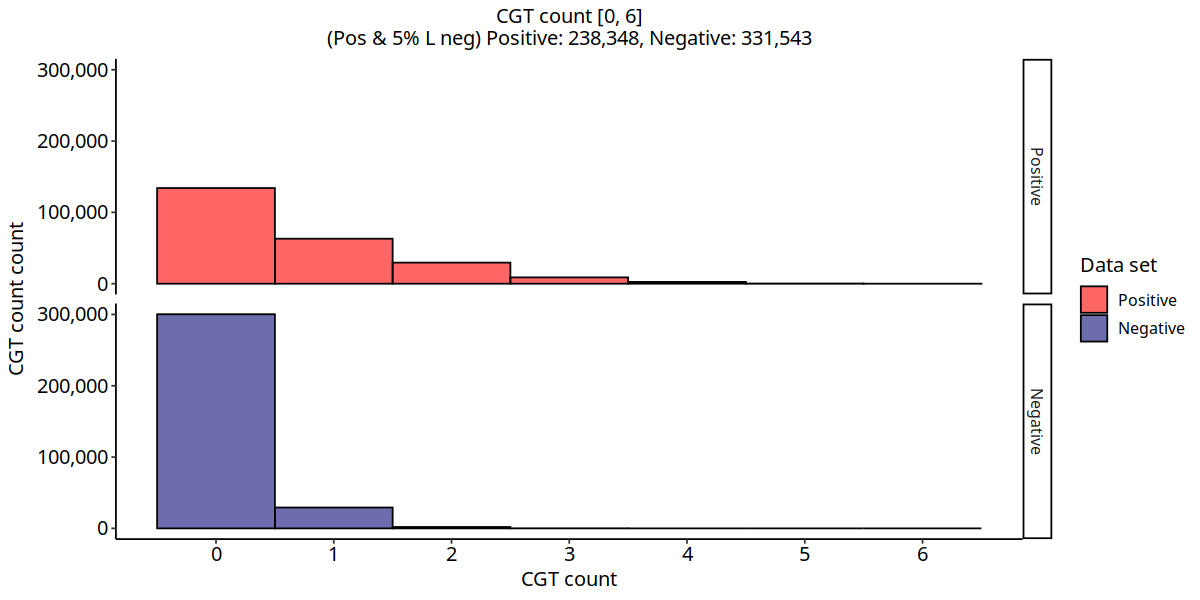

In [260]:
if (save_pdf == TRUE) {set_plot_dimensions(pdf_dims[1], pdf_dims[2])} else {set_plot_dimensions(10, 5)}
p <- plot_features(d, feature=feature)
p
if (save_pdf == TRUE) {ggsave(output_file, plot = p, width=pdf_dims[1], height=pdf_dims[2])}

### motif m6a count

In [261]:
#------------ Set output file ------------
feature <- "motif_m6a_count"
output_file_name <- sprintf("CTCF_%s.mokapot.%s_hist.pdf", file_root, feature)
output_file <- sprintf("%s/%s", output_folder, output_file_name)
print(output_file)

# save file
save_pdf <- TRUE
pdf_dims <- c(10,5)

[1] "/mmfs1/gscratch/stergachislab/mvollger/projects/ctcf-footprinting/mokapot_res/figures/CTCF_100bp_L_rle_kmer.mokapot.motif_m6a_count_hist.pdf"


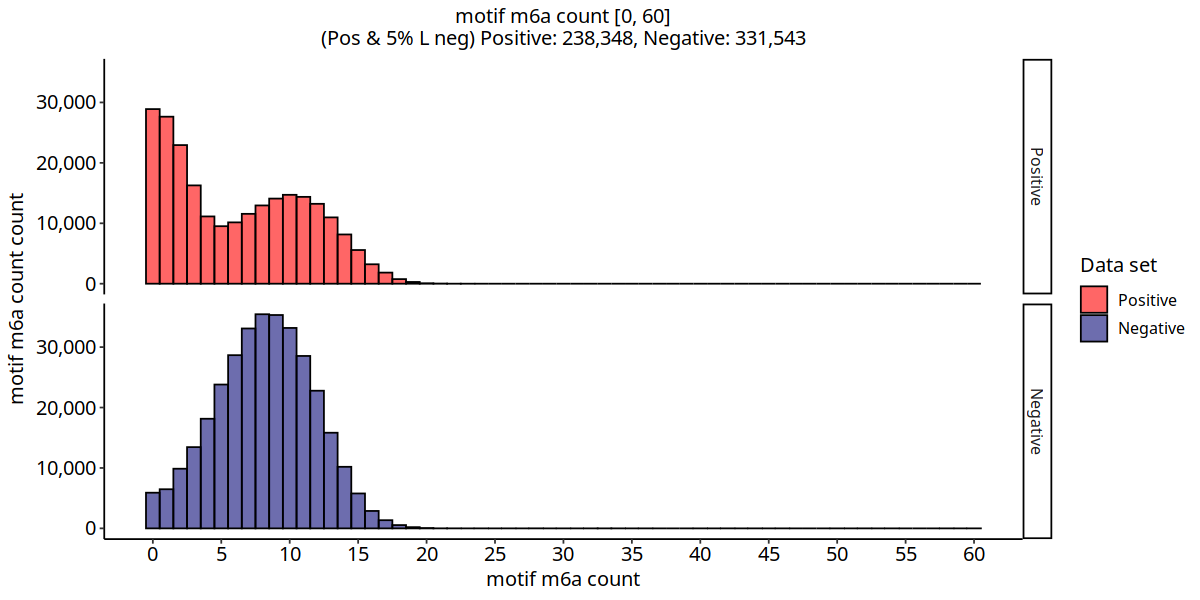

In [262]:
if (save_pdf == TRUE) {set_plot_dimensions(pdf_dims[1], pdf_dims[2])} else {set_plot_dimensions(10, 5)}
p <- plot_features(d, feature=feature)
p
if (save_pdf == TRUE) {ggsave(output_file, plot = p, width=pdf_dims[1], height=pdf_dims[2])}

### motif m6a fraction/proportion

In [263]:
#------------ Set output file ------------
feature <- "motif_m6a_prop"
output_file_name <- sprintf("CTCF_%s.mokapot.%s_hist.pdf", file_root, feature)
output_file <- sprintf("%s/%s", output_folder, output_file_name)
print(output_file)

# save file
save_pdf <- TRUE
pdf_dims <- c(10,5)

[1] "/mmfs1/gscratch/stergachislab/mvollger/projects/ctcf-footprinting/mokapot_res/figures/CTCF_100bp_L_rle_kmer.mokapot.motif_m6a_prop_hist.pdf"


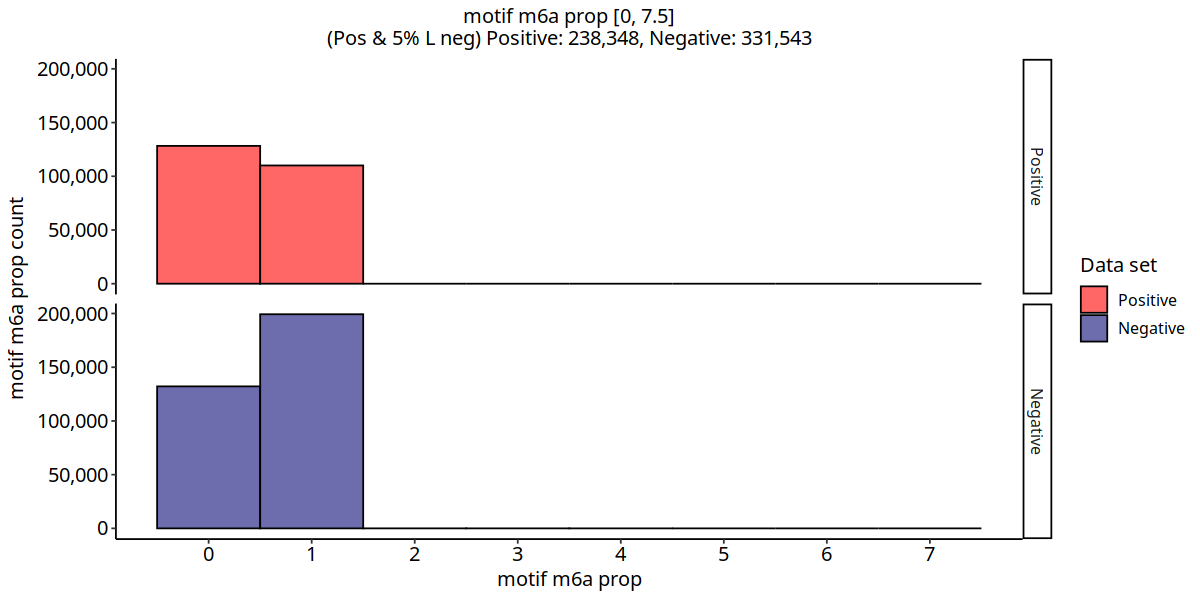

In [264]:
if (save_pdf == TRUE) {set_plot_dimensions(pdf_dims[1], pdf_dims[2])} else {set_plot_dimensions(10, 5)}
p <- plot_features(d, feature=feature)
p
if (save_pdf == TRUE) {ggsave(output_file, plot = p, width=pdf_dims[1], height=pdf_dims[2])}

Warning message:
“Removed 569863 rows containing non-finite values (`stat_bin()`).”
Warning message:
“Removed 2 rows containing missing values (`geom_bar()`).”


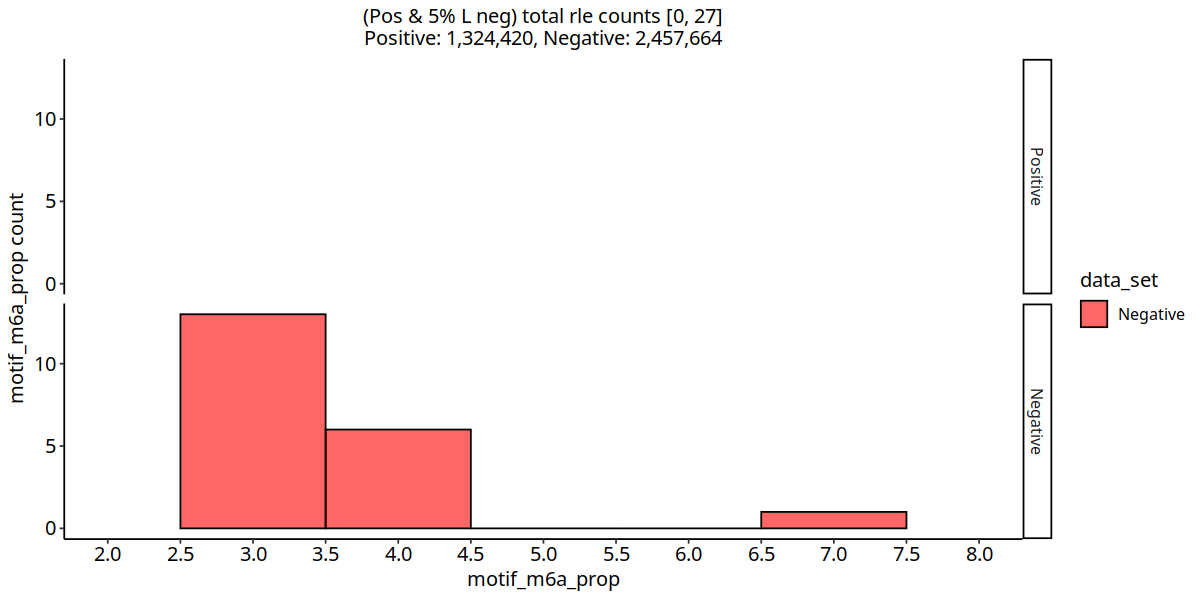

In [267]:
p <- ggplot(d, aes_string(x=feature, fill="data_set")) +
        geom_histogram(aes(color=data_set), color="black", 
                       alpha=0.6, position = 'identity', binwidth=1) +
        scale_fill_manual(values=c(mitch_cols[2], mitch_cols[5])) +#values=c("#132B43", "#56B1F7")) +
        scale_y_continuous(label=comma, name=sprintf("%s count", feature), breaks=pretty_breaks(n=4)) +#,
        scale_x_continuous(name=feature, breaks=pretty_breaks(n=10), limits=c(2, 8))+ #, limits=c(NA,30)) +

        facet_grid(rows=vars(data_set)) +
        ggtitle(plot_title) +
        theme_classic() +
        theme(text = font_info,
              axis.text = font_info,
              plot.title = element_text(family="ArialMT", size=12, hjust=0.5),)
p


### all features

In [352]:
#------------ Set output file ------------
feature <- "all_features"
output_file_name <- sprintf("CTCF_%s.mokapot.%s_hist.pdf", file_root, feature)
output_file <- sprintf("%s/%s", output_folder, output_file_name)
print(output_file)

# save file
save_pdf <- TRUE
pdf_dims <- c(10,5)

[1] "/mmfs1/gscratch/stergachislab/mvollger/projects/ctcf-footprinting/mokapot_res/figures/CTCF_100bp_L_rle_kmer.mokapot.all_features_hist.pdf"


In [329]:
features <- names(d)[3:(ncol(d)-4)]
length(features)
d_feat <- d[, ..features]
dim(d_feat)

[1] 163

[1] 569891    163

In [330]:
openPDF(output_file, pdf_dims)
for (feature in features) {
    p <- plot_features(d, feature=feature)
    print(p)
}
closePDF()

[1] "Saving plots to: /mmfs1/gscratch/stergachislab/mvollger/projects/ctcf-footprinting/mokapot_res/figures/CTCF_100bp_L_rle_kmer.mokapot.all_features_hist.pdf"
[1] "File saved."


### prop code issue

In [309]:
features <- names(d)[3:(ncol(d)-4)]
length(features)
d_feat <- d[, ..features]
dim(d_feat)

[1] 163

[1] 569891    163

In [288]:
d[match(features, names(d))]

SpecID,Label,msp_size,left_m6a_count,right_m6a_count,motif_m6a_count,left_AT_count,right_AT_count,motif_AT_count,left_AT_prop,⋯,rle_31,rle_32,rle_33,rle_34,rle_35,rle_max,Peptide,Proteins,scannr,data_set
<chr>,<int>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,⋯,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<int>,<int>,<int>,<fct>
chr10_100338605_+/m54329U_210323_190418/169477611/ccs,1,181,10,12,2,18,18,13,0.450,⋯,0,0,0,0,0,11,2,2,2,Positive
chr10_100338605_+/m54329U_210323_190418/173999297/ccs,1,134,9,11,8,18,18,13,0.450,⋯,0,0,0,0,0,3,3,3,3,Positive
chr10_100338605_+/m54329U_210323_190418/180160021/ccs,1,194,12,12,1,18,18,13,0.450,⋯,0,0,0,0,0,11,4,4,4,Positive
chr10_100338605_+/m54329U_210323_190418/27396441/ccs,1,181,14,14,3,17,18,13,0.425,⋯,0,0,0,0,0,9,5,5,5,Positive
chr10_100338605_+/m54329U_210323_190418/43450578/ccs,1,189,16,15,4,18,18,13,0.450,⋯,0,0,0,0,0,9,6,6,6,Positive
chr10_100338605_+/m54329U_210323_190418/46336112/ccs,1,165,10,8,2,18,18,13,0.450,⋯,0,0,0,0,0,10,7,7,7,Positive
chr10_100338605_+/m54329U_210326_192251/138151896/ccs,1,142,16,6,12,18,18,13,0.450,⋯,0,0,0,0,0,1,8,8,8,Positive
chr10_100338605_+/m54329U_210326_192251/40044403/ccs,1,155,13,14,1,18,18,13,0.450,⋯,0,0,0,0,0,11,9,9,9,Positive
chr10_100338605_+/m54329U_210326_192251/89197269/ccs,1,161,9,13,4,18,18,13,0.450,⋯,0,0,0,0,0,9,10,10,10,Positive


In [294]:
summary(d$rle_max)

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
  0.000   2.000   3.000   5.269   8.000  27.000 

In [319]:
#names(d_feat)[str_detect(colnames(d_feat), "prop")]
d_prop <- d_feat %>% select(all_of(names(d_feat)[str_detect(colnames(d_feat), "prop")]))

In [322]:
apply(d_prop, 2, max)

left_AT_prop  right_AT_prop  motif_AT_prop  left_m6a_prop right_m6a_prop 
     1.0000000      0.9750000      0.7714286      4.3636365      7.0769230 
motif_m6a_prop total_m6a_prop   AAA_m6a_prop   AAC_m6a_prop   AAG_m6a_prop 
     7.5000000      3.2903225      1.0000000      1.0000000      1.2500000 
  AAT_m6a_prop   ACA_m6a_prop   ACC_m6a_prop   ACG_m6a_prop   ACT_m6a_prop 
     1.0000000      1.5000000      1.0000000      1.0000000      1.0000000 
  AGA_m6a_prop   AGC_m6a_prop   AGG_m6a_prop   AGT_m6a_prop   ATA_m6a_prop 
     1.5000000      2.0000000      2.0000000      1.5000000      1.0000000 
  ATC_m6a_prop   ATG_m6a_prop   ATT_m6a_prop   CAA_m6a_prop   CAC_m6a_prop 
     1.0000000      1.0000000      1.0000000      1.0000000      2.0000000 
  CAG_m6a_prop   CAT_m6a_prop   CCA_m6a_prop   CCT_m6a_prop   CGA_m6a_prop 
     3.0000000      1.0000000      2.0000000      2.0000000      2.0000000 
  CGT_m6a_prop   CTA_m6a_prop   CTC_m6a_prop   CTG_m6a_prop   CTT_m6a_prop 
     2.0000000      1.0000000      3.0000000      2.0000000      1.5000000 
  GAA_m6a_prop   GAC_m6a_prop   GAG_m6a_prop   GAT_m6a_prop   GCA_m6a_prop 
     1.5000000      3.0000000      2.0000000      1.0000000      2.0000000 
  GCT_m6a_prop   GGA_m6a_prop   GGT_m6a_prop   GTA_m6a_prop   GTC_m6a_prop 
     3.0000000      2.0000000      2.0000000      1.5000000      2.0000000 
  GTG_m6a_prop   GTT_m6a_prop   TAA_m6a_prop   TAC_m6a_prop   TAG_m6a_prop 
     2.0000000      1.0000000      1.0000000      1.0000000      1.5000000 
  TAT_m6a_prop   TCA_m6a_prop   TCC_m6a_prop   TCG_m6a_prop   TCT_m6a_prop 
     1.0000000      1.0000000      2.0000000      2.0000000      1.5000000 
  TGA_m6a_prop   TGC_m6a_prop   TGG_m6a_prop   TGT_m6a_prop   TTA_m6a_prop 
     1.5000000      3.0000000      2.0000000      1.5000000      1.0000000 
  TTC_m6a_prop   TTG_m6a_prop   TTT_m6a_prop 
     1.5000000      1.2500000      1.0000000

In [332]:
prop_stats = apply(d_prop, 2, my.summary)

In [334]:
prop_stats

,left_AT_prop,right_AT_prop,motif_AT_prop,left_m6a_prop,right_m6a_prop,motif_m6a_prop,total_m6a_prop,AAA_m6a_prop,AAC_m6a_prop,AAG_m6a_prop,⋯,TCG_m6a_prop,TCT_m6a_prop,TGA_m6a_prop,TGC_m6a_prop,TGG_m6a_prop,TGT_m6a_prop,TTA_m6a_prop,TTC_m6a_prop,TTG_m6a_prop,TTT_m6a_prop
mean,4.822443e-01,4.731432e-01,4.187210e-01,4.162143e-01,4.349353e-01,5.245812e-01,2.473986e-01,4.992775e-02,9.643857e-02,1.673769e-01,⋯,1.189497e-01,2.123978e-01,1.834631e-01,2.839975e-01,3.789975e-01,2.136350e-01,3.643566e-02,1.316367e-01,1.251784e-01,5.387833e-02
sd,1.297932e-01,1.273801e-01,1.015786e-01,2.875141e-01,2.865155e-01,3.003268e-01,1.122667e-01,1.792439e-01,2.529224e-01,3.308730e-01,⋯,3.208027e-01,3.805753e-01,3.370466e-01,4.352609e-01,4.652946e-01,3.766526e-01,1.424309e-01,3.027115e-01,2.800040e-01,1.849037e-01
median,4.750000e-01,4.750000e-01,4.285714e-01,4.000000e-01,4.117647e-01,5.555556e-01,2.352941e-01,0.000000e+00,0.000000e+00,0.000000e+00,⋯,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
min,2.500000e-02,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,1.408451e-02,0.000000e+00,0.000000e+00,0.000000e+00,⋯,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
max,1.000000e+00,9.750000e-01,7.714286e-01,4.363637e+00,7.076923e+00,7.500000e+00,3.290322e+00,1.000000e+00,1.000000e+00,1.250000e+00,⋯,2.000000e+00,1.500000e+00,1.500000e+00,3.000000e+00,2.000000e+00,1.500000e+00,1.000000e+00,1.500000e+00,1.250000e+00,1.000000e+00
n,5.698910e+05,5.698910e+05,5.698910e+05,5.698910e+05,5.698910e+05,5.698910e+05,5.698910e+05,5.698910e+05,5.698910e+05,5.698910e+05,⋯,5.698910e+05,5.698910e+05,5.698910e+05,5.698910e+05,5.698910e+05,5.698910e+05,5.698910e+05,5.698910e+05,5.698910e+05,5.698910e+05


In [337]:
# turn off scientific
options(scipen=999)

In [342]:
bad_prop <- prop_stats[, prop_stats["max", ] > 1]
colnames(bad_prop)
bad_prop

[1] "left_m6a_prop"  "right_m6a_prop" "motif_m6a_prop" "total_m6a_prop"
 [5] "AAG_m6a_prop"   "ACA_m6a_prop"   "AGA_m6a_prop"   "AGC_m6a_prop"  
 [9] "AGG_m6a_prop"   "AGT_m6a_prop"   "CAC_m6a_prop"   "CAG_m6a_prop"  
[13] "CCA_m6a_prop"   "CCT_m6a_prop"   "CGA_m6a_prop"   "CGT_m6a_prop"  
[17] "CTC_m6a_prop"   "CTG_m6a_prop"   "CTT_m6a_prop"   "GAA_m6a_prop"  
[21] "GAC_m6a_prop"   "GAG_m6a_prop"   "GCA_m6a_prop"   "GCT_m6a_prop"  
[25] "GGA_m6a_prop"   "GGT_m6a_prop"   "GTA_m6a_prop"   "GTC_m6a_prop"  
[29] "GTG_m6a_prop"   "TAG_m6a_prop"   "TCC_m6a_prop"   "TCG_m6a_prop"  
[33] "TCT_m6a_prop"   "TGA_m6a_prop"   "TGC_m6a_prop"   "TGG_m6a_prop"  
[37] "TGT_m6a_prop"   "TTC_m6a_prop"   "TTG_m6a_prop"

,left_m6a_prop,right_m6a_prop,motif_m6a_prop,total_m6a_prop,AAG_m6a_prop,ACA_m6a_prop,AGA_m6a_prop,AGC_m6a_prop,AGG_m6a_prop,AGT_m6a_prop,⋯,TAG_m6a_prop,TCC_m6a_prop,TCG_m6a_prop,TCT_m6a_prop,TGA_m6a_prop,TGC_m6a_prop,TGG_m6a_prop,TGT_m6a_prop,TTC_m6a_prop,TTG_m6a_prop
mean,0.4162143,0.4349353,0.5245812,0.24739858,0.1673769,0.1907030,0.2746523,0.3043979,0.3954806,0.2146591,⋯,0.1133848,0.2727470,0.1189497,0.2123978,0.1834631,0.2839975,0.3789975,0.2136350,0.1316367,0.1251784
sd,0.2875141,0.2865155,0.3003268,0.11226667,0.3308730,0.3633201,0.4115444,0.4474848,0.4615245,0.3614180,⋯,0.2785363,0.4346843,0.3208027,0.3805753,0.3370466,0.4352609,0.4652946,0.3766526,0.3027115,0.2800040
median,0.4000000,0.4117647,0.5555556,0.23529412,0.0000000,0.0000000,0.0000000,0.0000000,0.0000000,0.0000000,⋯,0.0000000,0.0000000,0.0000000,0.0000000,0.0000000,0.0000000,0.0000000,0.0000000,0.0000000,0.0000000
min,0.0000000,0.0000000,0.0000000,0.01408451,0.0000000,0.0000000,0.0000000,0.0000000,0.0000000,0.0000000,⋯,0.0000000,0.0000000,0.0000000,0.0000000,0.0000000,0.0000000,0.0000000,0.0000000,0.0000000,0.0000000
max,4.3636365,7.0769230,7.5000000,3.29032250,1.2500000,1.5000000,1.5000000,2.0000000,2.0000000,1.5000000,⋯,1.5000000,2.0000000,2.0000000,1.5000000,1.5000000,3.0000000,2.0000000,1.5000000,1.5000000,1.2500000
n,569891.0000000,569891.0000000,569891.0000000,569891.00000000,569891.0000000,569891.0000000,569891.0000000,569891.0000000,569891.0000000,569891.0000000,⋯,569891.0000000,569891.0000000,569891.0000000,569891.0000000,569891.0000000,569891.0000000,569891.0000000,569891.0000000,569891.0000000,569891.0000000


In [348]:
sum(str_detect(colnames(d_feat), "prop"))

[1] 63

In [349]:
sprintf("Total prop cols: %s", sum(str_detect(colnames(d_feat), "prop")))
sprintf("Messed up cols: %s", length(colnames(bad_prop)))
print(colnames(bad_prop))

[1] "Total prop cols: 63"

[1] "Messed up cols: 39"

 [1] "left_m6a_prop"  "right_m6a_prop" "motif_m6a_prop" "total_m6a_prop"
 [5] "AAG_m6a_prop"   "ACA_m6a_prop"   "AGA_m6a_prop"   "AGC_m6a_prop"  
 [9] "AGG_m6a_prop"   "AGT_m6a_prop"   "CAC_m6a_prop"   "CAG_m6a_prop"  
[13] "CCA_m6a_prop"   "CCT_m6a_prop"   "CGA_m6a_prop"   "CGT_m6a_prop"  
[17] "CTC_m6a_prop"   "CTG_m6a_prop"   "CTT_m6a_prop"   "GAA_m6a_prop"  
[21] "GAC_m6a_prop"   "GAG_m6a_prop"   "GCA_m6a_prop"   "GCT_m6a_prop"  
[25] "GGA_m6a_prop"   "GGT_m6a_prop"   "GTA_m6a_prop"   "GTC_m6a_prop"  
[29] "GTG_m6a_prop"   "TAG_m6a_prop"   "TCC_m6a_prop"   "TCG_m6a_prop"  
[33] "TCT_m6a_prop"   "TGA_m6a_prop"   "TGC_m6a_prop"   "TGG_m6a_prop"  
[37] "TGT_m6a_prop"   "TTC_m6a_prop"   "TTG_m6a_prop"  


In [351]:
24/63*100

[1] 38.09524

In [297]:
my.summary <- function(x,...){
  c(mean=mean(x, ...),
    sd=sd(x, ...),
    median=median(x, ...),
    min=min(x, ...),
    max=max(x,...), 
    n=length(x))
}

# all these calls should give you the same results.
apply(d[match(features, names(d))], 2, my.summary)
#sapply(df, my.summary)
#do.call(cbind,lapply(df, my.summary))

Warning message in mean.default(x, ...):
“argument is not numeric or logical: returning NA”
Warning message in var(if (is.vector(x) || is.factor(x)) x else as.double(x), na.rm = na.rm):
“NAs introduced by coercion”
Warning message in mean.default(x, ...):
“argument is not numeric or logical: returning NA”
Warning message in mean.default(x, ...):
“argument is not numeric or logical: returning NA”
Warning message in mean.default(x, ...):
“argument is not numeric or logical: returning NA”
Warning message in mean.default(x, ...):
“argument is not numeric or logical: returning NA”
Warning message in mean.default(x, ...):
“argument is not numeric or logical: returning NA”
Warning message in mean.default(x, ...):
“argument is not numeric or logical: returning NA”
Warning message in mean.default(x, ...):
“argument is not numeric or logical: returning NA”
Warning message in mean.default(x, ...):
“argument is not numeric or logical: returning NA”
Warning message in mean.default(x, ...):
“argumen

Warning message in mean.default(x, ...):
“argument is not numeric or logical: returning NA”
Warning message in mean.default(x, ...):
“argument is not numeric or logical: returning NA”
Warning message in mean.default(x, ...):
“argument is not numeric or logical: returning NA”
Warning message in mean.default(x, ...):
“argument is not numeric or logical: returning NA”
Warning message in mean.default(x, ...):
“argument is not numeric or logical: returning NA”
Warning message in mean.default(x, ...):
“argument is not numeric or logical: returning NA”
Warning message in mean.default(x, ...):
“argument is not numeric or logical: returning NA”
Warning message in mean.default(x, ...):
“argument is not numeric or logical: returning NA”
Warning message in mean.default(x, ...):
“argument is not numeric or logical: returning NA”
Warning message in mean.default(x, ...):
“argument is not numeric or logical: returning NA”
Warning message in mean.default(x, ...):
“argument is not numeric or logical: re

,SpecID,Label,msp_size,left_m6a_count,right_m6a_count,motif_m6a_count,left_AT_count,right_AT_count,motif_AT_count,left_AT_prop,⋯,rle_31,rle_32,rle_33,rle_34,rle_35,rle_max,Peptide,Proteins,scannr,data_set
mean,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,⋯,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA
sd,NA,0,80.9766756232999,3.74701779978167,3.1738727370797,4.43037992762618,1.79632030661142,3.19520677901691,3.38390405225321,0.0449080076652856,⋯,0,0,0,0,0,5.54000550416148,47.1981638060917,47.1981638060917,47.1981638060917,NA
median,chr10_100433947_-/m64076_221119_202646/27918391/ccs,1,252,12,9,3,18,18,16,0.450,⋯,0,0,0,0,0,9,83,83,83,Positive
min,chr10_100338605_+/m54329U_210323_190418/169477611/ccs,1,85,2,1,0,14,13,8,0.350,⋯,0,0,0,0,0,0,2,2,2,Positive
max,chr10_100562106_+/m64076_221119_202646/167184118/ccs,1,586,18,15,16,20,23,18,0.500,⋯,0,0,0,0,0,17,164,164,164,Positive
n,163,163,163,163,163,163,163,163,163,163,⋯,163,163,163,163,163,163,163,163,163,163


## feature hists